### Imports

In [66]:
from openai import AzureOpenAI
from openai import OpenAI
from dotenv import load_dotenv

import pandas as pd
import os
import json
import ast

### Load Environment Variables / Configurations

In [5]:
load_dotenv()

api_key = os.getenv('OPENAI_API_KEY')
api_base = os.getenv('ENDPOINT') # endpoint
deployment_name = 'gpt-4o'
api_version = '2024-02-15-preview'


### Test the Azure Endpoints

In [6]:
client = AzureOpenAI(
    api_key = api_key,
    api_version = api_version,
    base_url =f"{api_base}/openai/deployments/{deployment_name}"
)

#### GPT-4o call

In [7]:
# GPT4 / 4o JSON Structure - Content has a 'type' to be either text or image data

response = client.chat.completions.create(
    model = deployment_name,
    messages = [
        {"role": "system", "content": "You are a helpful assistant. "},
        {"role": "user", "content": [
            {
                "type": "text",
                "text": "Test prompt. Please acknowledge."
            }
        ] }
    ],
    max_tokens=2000
)

print(response)
print(response.choices[0].message.content)

ChatCompletion(id='chatcmpl-ABRM2tcfABQAimD6tYFbk2YjDrgfU', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Acknowledged! How can I assist you today?', refusal=None, role='assistant', function_call=None, tool_calls=None), content_filter_results={'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_material_text': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}})], created=1727290122, model='gpt-4o-2024-05-13', object='chat.completion', service_tier=None, system_fingerprint='fp_80a1bad4c7', usage=CompletionUsage(completion_tokens=10, prompt_tokens=24, total_tokens=34, completion_tokens_details=None), prompt_filter_results=[{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}

#### GPT-4o Image Test

Data URL: 

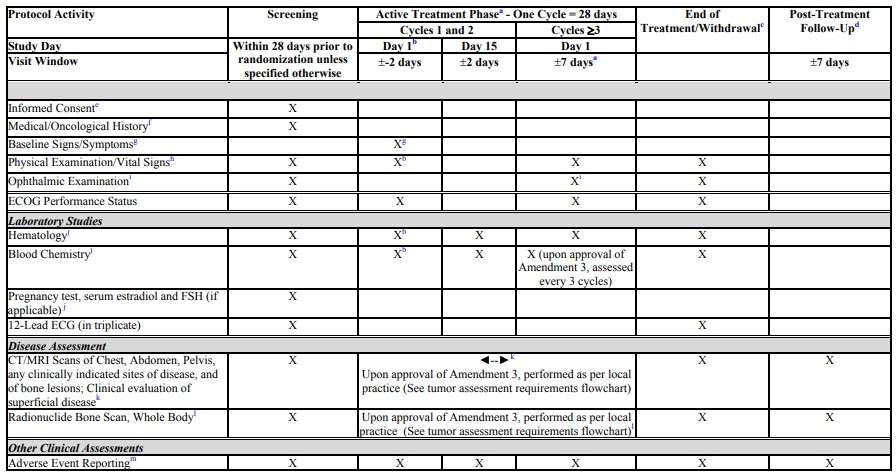

In [8]:
# GPT4 / GPT-4o Vision 
import base64
from mimetypes import guess_type

# Function to encode a local image into data URL 
def local_image_to_data_url(image_path):
    # Guess the MIME type of the image based on the file extension
    mime_type, _ = guess_type(image_path)
    if mime_type is None:
        mime_type = 'application/octet-stream'  # Default MIME type if none is found

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the data URL
    return f"data:{mime_type};base64,{base64_encoded_data}"

# Example usage
cwd = os.getcwd()

image_path = 'files/Pfizer_Paloma3/SOA_1.jpeg'
image_path = os.path.normpath(image_path)
image_path = os.path.join(cwd,image_path)

data_url = local_image_to_data_url(image_path)
print("Data URL:", data_url)

In [9]:
response = client.chat.completions.create(
    model = deployment_name,
    messages = [
        {"role": "system", "content": "You are a helpful assistant. "},
        {"role": "user", "content": [
            {
                "type": "text",
                "text": "Describe this picture:"
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": data_url
                }
            }
        ] }
    ],
    max_tokens=2000
)

print(response)
print(response.choices[0].message.content)

ChatCompletion(id='chatcmpl-ABRM4wGYn3s9Bp1yJizOlOLIxRlja', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='This picture depicts a table outlining a clinical study protocol with various activities and their corresponding timing windows. Here is a detailed description:\n\n1. **Table Headings**:\n   - The columns are divided into several sections indicating different study phases and specific days within each phase: \n     - Screening \n     - Active Treatment Phase (Cycles 1 and 2: Day 1, Day 15; Cycles ≥3: Day 1) \n     - End of Treatment/Withdrawal\n     - Post-Treatment Follow-Up\n   \n2. **Protocol Activities**:\n   - The rows list specific activities or assessments, including:\n     - Informed Consent\n     - Medical/Oncological History\n     - Baseline Signs/Symptoms\n     - Physical Examination/Vital Signs\n     - Ophthalmic Examination\n     - ECOG Performance Status\n     - Laboratory Studies\n       - Hematology\n       - Bl

## Edit Check UAT Data Activity

### Step 1: Extract the required form_name / field_names from the check description or logic

In [40]:
sample_edit_check = '''
Edit Check Name: AE End Date Before Start Date
Edit Check Description: Validates that the AE end date is later than the AE start date to ensure logical consistency
Edit Check Logic: AE.AEENDAT < AE.AESTDAT
'''

In [11]:
form_field_extraction_prompt = f'''
You are an expert clinical database builder. 
Task: Analyze the following text and extract all Forms and Fields from it. 

<Instructions>
- Forms and Fields create a hierarchical structure, where multiple Fields can be part of a Form
- Output your results in the format of a JSON dictionary, where Forms are the keys and the list of Fields is the value
- Provide only the output JSON in your response. Do not add any words before it.
- Consider the examples of the task below. Everything after > is the JSON dictionary output. Examples:
- AE.AESER IS NOT NULL AND AE.AEOUT IS NULL > {{"AE": ["AESER","AEOUT"]}}
- (AE.AESDTH = 'Y' OR AE.AESLIFE = 'Y' OR AE.AESDISAB = 'Y') AND AE.AESER = N > {{"AE": ["AESDTH","AESLIFE","AESDISAB","AESER"]}}
</Instructions>

Below is the text to analyze:
<text>
{sample_edit_check}
</text>

Answer:
'''

In [12]:
# validate our prompt is output as expected
print(form_field_extraction_prompt)


You are an expert clinical database builder. 
Task: Analyze the following text and extract all Forms and Fields from it. 

<Instructions>
- Forms and Fields create a hierarchical structure, where multiple Fields can be part of a Form
- Output your results in the format of a JSON dictionary, where Forms are the keys and the list of Fields is the value
- Provide only the output JSON in your response. Do not add any words before it.
- Consider the examples of the task below. Everything after > is the JSON dictionary output. Examples:
- AE.AESER IS NOT NULL AND AE.AEOUT IS NULL > {"AE": ["AESER","AEOUT"]}
- (AE.AESDTH = 'Y' OR AE.AESLIFE = 'Y' OR AE.AESDISAB = 'Y') AND AE.AESER = N > {"AE": ["AESDTH","AESLIFE","AESDISAB","AESER"]}
</Instructions>

Below is the text to analyze:
<text>

Edit Check Name: AE End Date After Start Date
Edit Check Description: Validates that the AE end date is later than the AE start date to ensure logical consistency
Edit Check Logic: AE.AEENDAT < AE.AESTDAT

<

In [13]:
response = client.chat.completions.create(
    model = deployment_name,
    messages = [
        {"role": "system", "content": "You are a helpful assistant. "},
        {"role": "user", "content": [
            {
                "type": "text",
                "text": form_field_extraction_prompt
            }
        ] }
    ],
    max_tokens=2000
)

print(response)
print(response.choices[0].message.content)

ChatCompletion(id='chatcmpl-ABRMDRCiTC2qL3iLgpgBye0ta4CdR', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{\n  "AE": ["AEENDAT", "AESTDAT"]\n}', refusal=None, role='assistant', function_call=None, tool_calls=None), content_filter_results={'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_material_text': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}})], created=1727290133, model='gpt-4o-2024-05-13', object='chat.completion', service_tier=None, system_fingerprint='fp_80a1bad4c7', usage=CompletionUsage(completion_tokens=16, prompt_tokens=281, total_tokens=297, completion_tokens_details=None), prompt_filter_results=[{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, '

In [14]:
# extract the message content from the model response, parse it as a json
message = response.choices[0].message.content
data = json.loads(message)

print(data)


{'AE': ['AEENDAT', 'AESTDAT']}


### Step 2: Extract additional metadata about the forms identified above
- We want our test data to be easily load-able into the EDC, so we should conform it to the structure of the identified forms
- The metadata could be pulled from a Metadata Repository (MDR) or directly from the EDC System
- For the purposes of the workshop we have provided a CSV of AE form metadata (sourced from the CDISC Library API) in: `/files/ae_form_metadata.csv` 

In [15]:
cwd = os.getcwd()

path_file = 'files/ae_form_metadata.csv'
path_file = os.path.normpath(path_file)
path_file = os.path.join(cwd,path_file)

form_data = pd.read_csv(path_file)
form_data.head()


,form_name,field_definition,field_implementationNotes,field_label,field_mappingInstructions,field_name,field_ordinal,field_prompt,field_questionText,field_simpleDatatype,field_codelistSubmissionValues,field_codelistTerms
0,AE,A unique identifier for a study.,Although this field is not typically captured ...,Study Identifier,Maps directly to the SDTMIG variable listed in...,STUDYID,1,[Protocol/Study],What is the study identifier?,Char,NaN,NaN
1,AE,A unique identifier for a site within a study.,Paper: This is typically preprinted in the hea...,Study Site Identifier,Maps directly to the SDTMIG variable listed in...,SITEID,2,Site (Identifier),What is the site identifier?,Char,NaN,NaN
2,AE,A unique subject identifier within a site and ...,Paper: This is typically recorded in the heade...,Subject Identifier for the Study,Maps directly to the SDTMIG variable listed in...,SUBJID,3,[Subject/Participant] (Identifier),What [is/was] the (study) [subject/participant...,Char,NaN,NaN
3,AE,The reported or prespecified name of the adver...,Can be represented either as an open-entry fie...,Reported Term for the Adverse Event,Maps directly to the SDTMIG variable listed in...,AETERM,8,Adverse Event,What is the adverse event term?,Char,NaN,NaN
4,AE,"The start date of the adverse event, represent...",NaN,Adverse Event Start Date,This does not map directly to an SDTMIG variab...,AESTDAT,11,Start Date,What is the adverse event start date?,Char,NaN,NaN


In [16]:
# narrow the metadata to only the fields required for generating the dataset
form_data = form_data[['form_name','field_name','field_prompt','field_questionText','field_simpleDatatype','field_codelistTerms']]
form_data.head(n=10)

,form_name,field_name,field_prompt,field_questionText,field_simpleDatatype,field_codelistTerms
0,AE,STUDYID,[Protocol/Study],What is the study identifier?,Char,NaN
1,AE,SITEID,Site (Identifier),What is the site identifier?,Char,NaN
2,AE,SUBJID,[Subject/Participant] (Identifier),What [is/was] the (study) [subject/participant...,Char,NaN
3,AE,AETERM,Adverse Event,What is the adverse event term?,Char,NaN
4,AE,AESTDAT,Start Date,What is the adverse event start date?,Char,NaN
5,AE,AESTTIM,Start Time,What is the adverse event start time?,Char,NaN
6,AE,AEENDAT,End Date,What was the adverse event end date?,Char,NaN
7,AE,AEENTIM,End Time,What was the adverse event end time?,Char,NaN
8,AE,AESEV,Severity,What is the severity of the adverse event?,Char,"['MILD','MODERATE','SEVERE']"
9,AE,AETOXGR,[NCI CTCAE/ Name of the scale] (Toxicity) Grade,What is the [NCI CTCAE/Name of scale (toxicity...,Char,"[1,2,3,4,5]"


### Step 3: Create SQL Code to test the Edit Check

In [19]:
json_form_data = form_data.to_json(orient = 'records')
json_form_data = json.loads(json_form_data)
print(json_form_data)

[{'form_name': 'AE', 'field_name': 'STUDYID', 'field_prompt': '[Protocol/Study]', 'field_questionText': 'What is the study identifier?', 'field_simpleDatatype': 'Char', 'field_codelistTerms': None}, {'form_name': 'AE', 'field_name': 'SITEID', 'field_prompt': 'Site (Identifier)', 'field_questionText': 'What is the site identifier?', 'field_simpleDatatype': 'Char', 'field_codelistTerms': None}, {'form_name': 'AE', 'field_name': 'SUBJID', 'field_prompt': '[Subject/Participant] (Identifier)', 'field_questionText': 'What [is/was] the (study) [subject/participant] identifier?', 'field_simpleDatatype': 'Char', 'field_codelistTerms': None}, {'form_name': 'AE', 'field_name': 'AETERM', 'field_prompt': 'Adverse Event', 'field_questionText': 'What is the adverse event term?', 'field_simpleDatatype': 'Char', 'field_codelistTerms': None}, {'form_name': 'AE', 'field_name': 'AESTDAT', 'field_prompt': 'Start Date', 'field_questionText': 'What is the adverse event start date?', 'field_simpleDatatype': '

In [23]:
create_sql_prompt = f'''

You are an expert clinical database builder.
Task: Analyze the following Edit Check (EC) `text` and create a SQL query. Forms and Fields create a hierarchical structure, where multiple Fields can be part of a Form. Forms are parents and Fields are children. Both Forms and Fields are used to collect data during a clinical trial. Do not provide any explanation, only the SQL query. Do not provide any text before the SQL. 

<Instructions>
- Add a prefix to the select clause depending on the form name column to show from which table each column is taken.
    Here is an example:
    original column: AEREL
    form name column: AE
    SQL Command: SELECT AE.AEREL AS AEREL

- Always include the subjectID column in the SELECT clause
</Instructions>

Below is the text to analyze as well as the form_field_properties dictionary:
<Text>
{sample_edit_check}
</Text>

<form_field_properties_dictionary>
{json_form_data}
</form_field_properties_dictionary>

Answer:
'''

In [31]:
response = client.chat.completions.create(
    model = deployment_name,
    messages = [
        {"role": "system", "content": "You are a helpful assistant. "},
        {"role": "user", "content": [
            {
                "type": "text",
                "text": create_sql_prompt
            }
        ] }
    ],
    max_tokens=2000
)

print(response)
print(response.choices[0].message.content)

sql_query = response.choices[0].message.content

ChatCompletion(id='chatcmpl-ABT8MtAjpaSZJ2AGjF4CINU90k1YD', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='```sql\nSELECT AE.SUBJID AS SUBJECTID, AE.AEENDAT AS AEENDAT, AE.AESTDAT AS AESTDAT \nFROM AE \nWHERE AE.AEENDAT < AE.AESTDAT;\n```', refusal=None, role='assistant', function_call=None, tool_calls=None), content_filter_results={'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}})], created=1727296962, model='gpt-4o-2024-05-13', object='chat.completion', service_tier=None, system_fingerprint='fp_67802d9a6d', usage=CompletionUsage(completion_tokens=47, prompt_tokens=2086, total_tokens=2133, completion_tokens_details=None), prompt_filter_results=[{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'dete

## Step 4: Final Dataset Generation

In [81]:
create_dataset_prompt = f'''
Task: Your task is to generate a test dataset that will help verify an edit check (EC) (mentioned in `text` section).

<General Instructions>
- Generate a JSON-like dictionary with the data {{{{"Table Name": [{{<field_codelistTerms' key value>}},{{<field_codelistTerms' key value>}}],
"Table Name": {{<field_codelistTerms' value>}}, {{<field_codelistTerms' value>}}].....}}}}
- Each SUBJID should be unique and follow this format XXXXXXXX, where each X is a random unique number. The name of the column MUST be SUBJID.
- To generate a data row in your dataset, you can choose from the field_codelistTerms list mentioned inside the form_field_properties_dictionary.
- If there are no field_codelistTerms inside the form_field_properties_dictionary, try to create them yourself. To better understand the type of data needed, use the value inside 'field_questionText' and 'field_simpleDatatype' keys for that record.
- <Add a column named test_outcome to your data>
    flag test cases that fire the edit check with Q.
    flag test cases that do not fire the edit check as NQ
    Only test the logic of the provided 'sql_query'.
</Add a column named test_outcome to your data>
- <Add a column named test_scenarios to your data>
In this column, explain why you marked the value as Q or NQ.
</Add a column named test_scenarios to your data>
- It is crucial that your generated dataset inclues all possible test scenarios (edge-cases) to test the edit check (EC). Every field mentioned inside the `text` MUST be connect with a test scenario.
- You MUST add a not null check for each field that is mentioned inside the `text`
- You MUST also include the edge case when all items are null.
</General Instructions>

<Output Format Instructions>
- It is critical to provide ONLY the generated dataset. Do not add any extra comments or explanations before the dataset. The ONLY output should be the JSON-like dictionary and nothing else. 
- DO NOT output anything other than the generated dataset. Do not label it with the tag 'json'.
- Output null values as empty strings
<Output Format Instructions>

There are 3 pieces of information to help you in the above instructions:
<text>
{sample_edit_check}
</text>

<sql_query>
{sql_query}
</sql_query>

<form_field_properties>
{json_form_data}
</form_field_properties>

Answer:
'''

In [38]:
print(create_dataset_prompt)


Task: Your task is to generate a test dataset that will help verify an edit check (EC) (mentioned in `text` section).

<General Instructions>
- Generate a JSON-like dictionary with the data {{"Table Name": [{<field_codelistTerms' key value>},{<field_codelistTerms' key value>}],
"Table Name": {<field_codelistTerms' value>}, {<field_codelistTerms' value>}].....}}
- Each SUBJID should be unique and follow this format XXXXXXXX, where each X is a random unique number. The name of the column MUST be SUBJID.
- To generate a data row in your dataset, you can choose from the field_codelistTerms list mentioned inside the form_field_properties_dictionary.
- If there are no field_codelistTerms inside the form_field_properties_dictionary, try to create them yourself. To better understand the type of data needed, use the value inside 'field_questionText' and 'field_simpleDatatype' keys for that record.
- <Add a column named test_outcome to your data>
    flag test cases only when they comply with t

In [82]:
response = client.chat.completions.create(
    model = deployment_name,
    messages = [
        {"role": "system", "content": "You are a helpful assistant. "},
        {"role": "user", "content": [
            {
                "type": "text",
                "text": create_dataset_prompt
            }
        ] }
    ],

)

print(response.choices[0].message.content)

dataset = response.choices[0].message.content

{
    "AE": [
        {
            "STUDYID": "STUDY1",
            "SITEID": "SITE1",
            "SUBJID": "12345678",
            "AETERM": "Headache",
            "AESTDAT": "2023-01-10",
            "AESTTIM": "08:00",
            "AEENDAT": "2023-01-11",
            "AEENTIM": "18:00",
            "AESEV": "MILD",
            "AETOXGR": "1",
            "AESER": "N",
            "AESDTH": "N",
            "AESLIFE": "N",
            "AESHOSP": "N",
            "AESDISAB": "N",
            "AESCONG": "N",
            "AESMIE": "N",
            "AEREL": "",
            "AEACN": "DOSE NOT CHANGED",
            "AEOUT": "RECOVERED/RESOLVED",
            "AEMODIFY": "",
            "AELLT": "",
            "AELLTCD": "",
            "AEPTCD": "",
            "AEHLT": "",
            "AEHLTCD": "",
            "AEHLGT": "",
            "AEHLGTCD": "",
            "AESOC": "",
            "AESOCCD": "",
            "test_outcome": "NQ",
            "test_scenarios": "End date is after 

In [100]:
# extract the response and cast to a dictionary
dataset = response.choices[0].message.content
dataset = ast.literal_eval(dataset)

# temp store for dataframes
df_l = []

# for each output dataset in our dict
for key in dataset.keys():
    
    # get the values and create a dataframe from it, append to our temp store
    values = dataset.get(key)
    df = pd.DataFrame(values)
    df_l.append(df)

df_l[0].head(n = 10)

,STUDYID,SITEID,SUBJID,AETERM,AESTDAT,AESTTIM,AEENDAT,AEENTIM,AESEV,AETOXGR,...,AELLTCD,AEPTCD,AEHLT,AEHLTCD,AEHLGT,AEHLGTCD,AESOC,AESOCCD,test_outcome,test_scenarios
0,STUDY1,SITE1,12345678,Headache,2023-01-10,08:00,2023-01-11,18:00,MILD,1,...,,,,,,,,,NQ,End date is after start date
1,STUDY2,SITE2,87654321,Nausea,2023-01-12,09:00,2023-01-11,17:00,MODERATE,2,...,,,,,,,,,Q,End date is before start date
2,STUDY3,SITE3,23456789,Fatigue,2023-01-15,10:00,2023-01-15,15:00,SEVERE,3,...,,,,,,,,,NQ,End date is the same as start date
3,STUDY4,SITE4,34567890,Dizziness,,,,,MILD,2,...,,,,,,,,,NQ,Both start and end dates are null
4,STUDY5,SITE5,45678901,Fever,2023-02-15,07:00,,,SEVERE,4,...,,,,,,,,,NQ,End date is null
5,STUDY6,SITE6,56789012,Muscle pain,,,2023-03-11,22:00,MODERATE,2,...,,,,,,,,,NQ,Start date is null
